## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem
from sklearn.linear_model import LogisticRegressionCV
import torch

seed = 1234
np.random.seed(seed) 

Part 1: Scaling

In [16]:
# 1. Setup the paths
base_path = "." 
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

# 2. Read CSV file
df = pd.read_csv(csv_file)

# Lists to store our data
data = []   # This will become X
labels = [] # This will become y

# Define a fixed size for images. For example, MINST is 28*28, here we do 64*64 
IMG_SIZE = 64

print("Loading images... this might take a moment.")

# 3. Loop through the CSV and load images
for index, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']

    img_path = os.path.join(images_folder, img_name)

    # Check if file actually exists to avoid errors
    if os.path.exists(img_path):
        # Load image in Grayscale (usually sufficient for emotion detection)
        # If you want color, remove the second argument.
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_array is not None:
            # Resize the image (Crucial step!)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            # Flatten the image
            # This converts the 2D image (64x64) into a 1D row of numbers (4096,)
            # This matches the format your professor used for X
            flat_array = new_array.flatten()
            
            data.append(flat_array)
            labels.append(emotion)

# 4. Convert to Numpy Arrays (X and y)
X = np.array(data)
y = np.array(labels)

print("Data loaded successfully!")
print(f"Features (X) shape: {X.shape}") # Should be (Number of images, 4096)
print(f"Labels (y) shape: {y.shape}")    # Should be (Number of images,)


Loading images... this might take a moment.
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)


## Data Exploration and Visualization

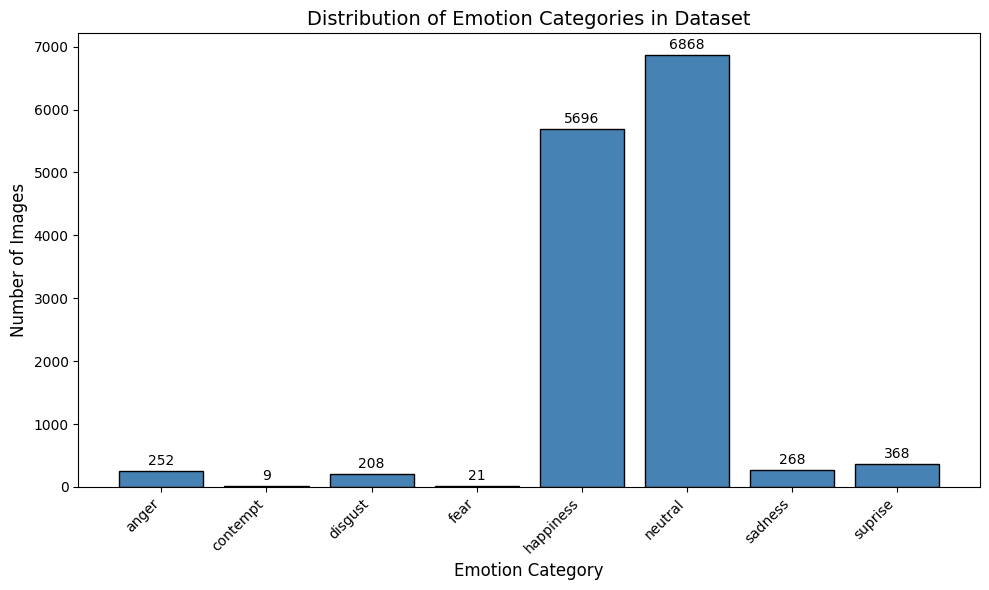


=== Dataset Summary ===
Total number of images: 13690
Number of emotion categories: 8

Class distribution:
  anger: 252 (1.8%)
  contempt: 9 (0.1%)
  disgust: 208 (1.5%)
  fear: 21 (0.2%)
  happiness: 5696 (41.6%)
  neutral: 6868 (50.2%)
  sadness: 268 (2.0%)
  suprise: 368 (2.7%)


In [4]:
# 1. Class Distribution - Bar Chart
emotion_counts = pd.Series(y).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(emotion_counts.index, emotion_counts.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Emotion Category', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Distribution of Emotion Categories in Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, emotion_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Dataset Summary ===")
print(f"Total number of images: {len(y)}")
print(f"Number of emotion categories: {len(emotion_counts)}")
print(f"\nClass distribution:")
for emotion, count in emotion_counts.items():
    percentage = count / len(y) * 100
    print(f"  {emotion}: {count} ({percentage:.1f}%)")

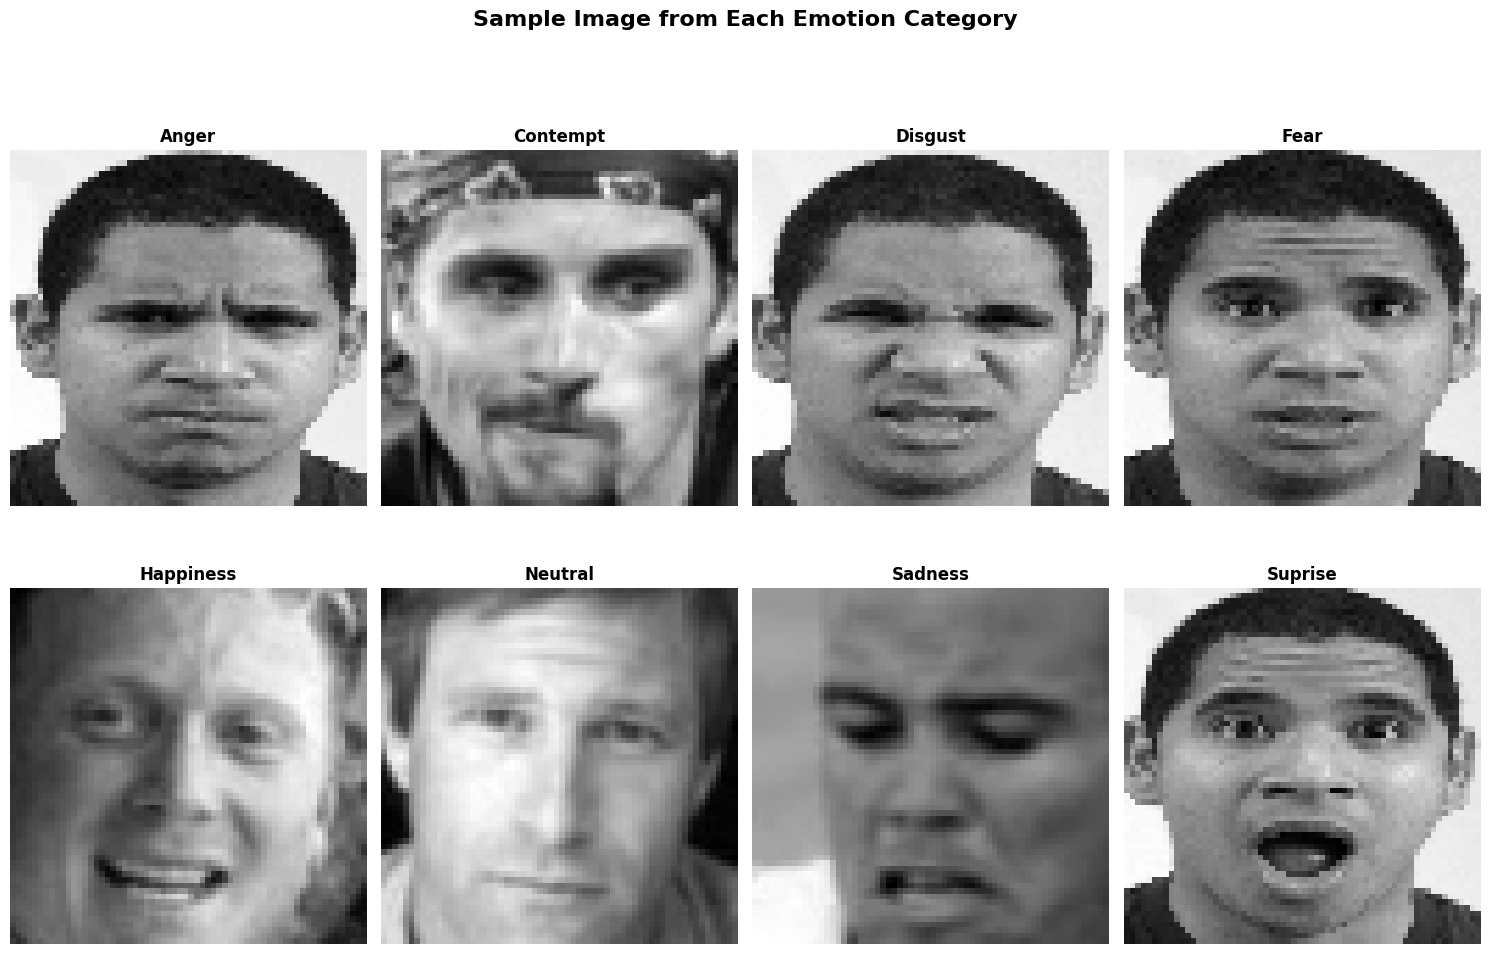

In [21]:
# 2. Sample Image from Each Emotion Category
unique_emotions = np.unique(y)
n_emotions = len(unique_emotions)

# Create a grid to display one sample from each emotion
fig, axes = plt.subplots(2, (n_emotions + 1) // 2, figsize=(15, 10))
axes = axes.flatten()

for i, emotion in enumerate(unique_emotions):
    # Get first image of this emotion
    idx = np.where(y == emotion)[0][0]
    axes[i].imshow(X[idx].reshape(64, 64), cmap='gray')
    axes[i].set_title(f'{emotion.capitalize()}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

# Hide any extra subplots
for j in range(len(unique_emotions), len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample Image from Each Emotion Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

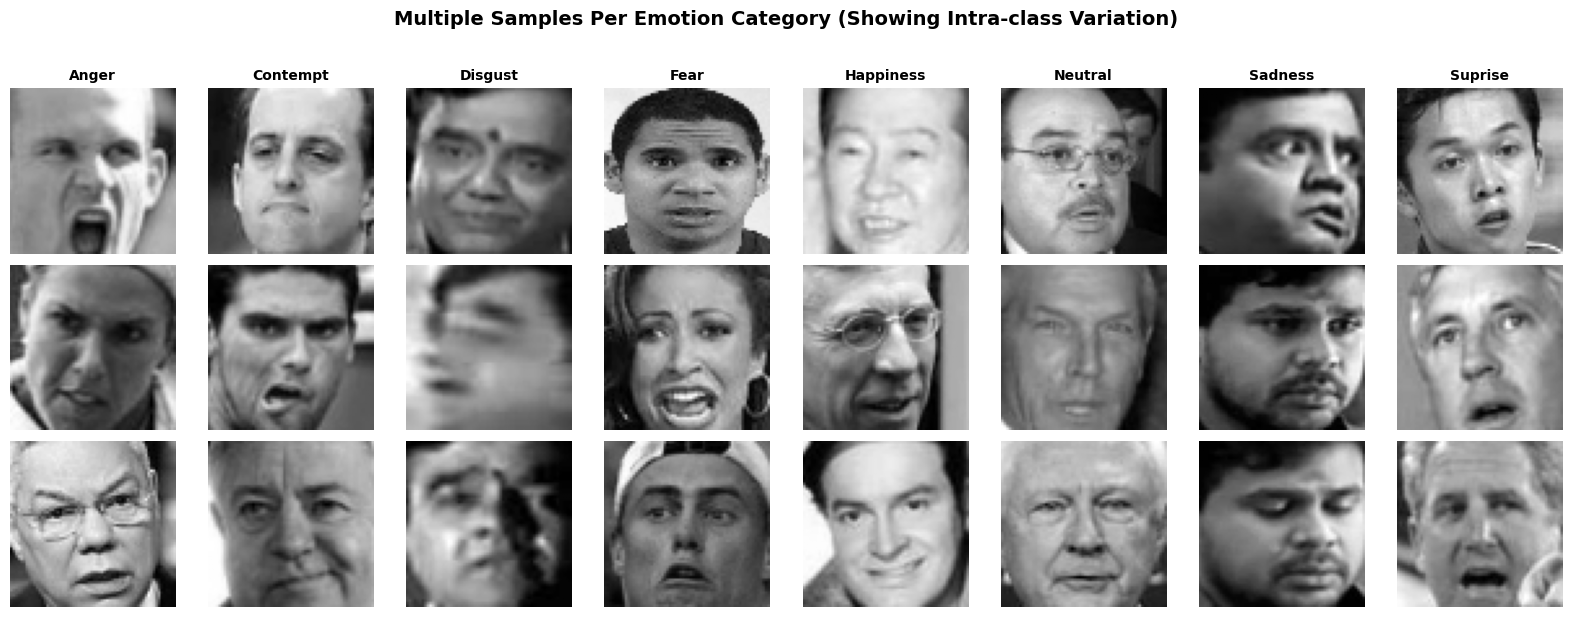

In [6]:
# 3. Multiple Samples Per Emotion (3x8 grid showing variety within each class)
n_samples_per_class = 3

fig, axes = plt.subplots(n_samples_per_class, n_emotions, figsize=(16, 6))

for j, emotion in enumerate(unique_emotions):
    # Get indices for this emotion
    emotion_indices = np.where(y == emotion)[0]
    # Randomly select samples (or take first few if not enough)
    n_available = min(n_samples_per_class, len(emotion_indices))
    sample_indices = np.random.choice(emotion_indices, n_available, replace=False)
    
    for i in range(n_samples_per_class):
        if i < n_available:
            axes[i, j].imshow(X[sample_indices[i]].reshape(64, 64), cmap='gray')
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(emotion.capitalize(), fontsize=10, fontweight='bold')

plt.suptitle('Multiple Samples Per Emotion Category (Showing Intra-class Variation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

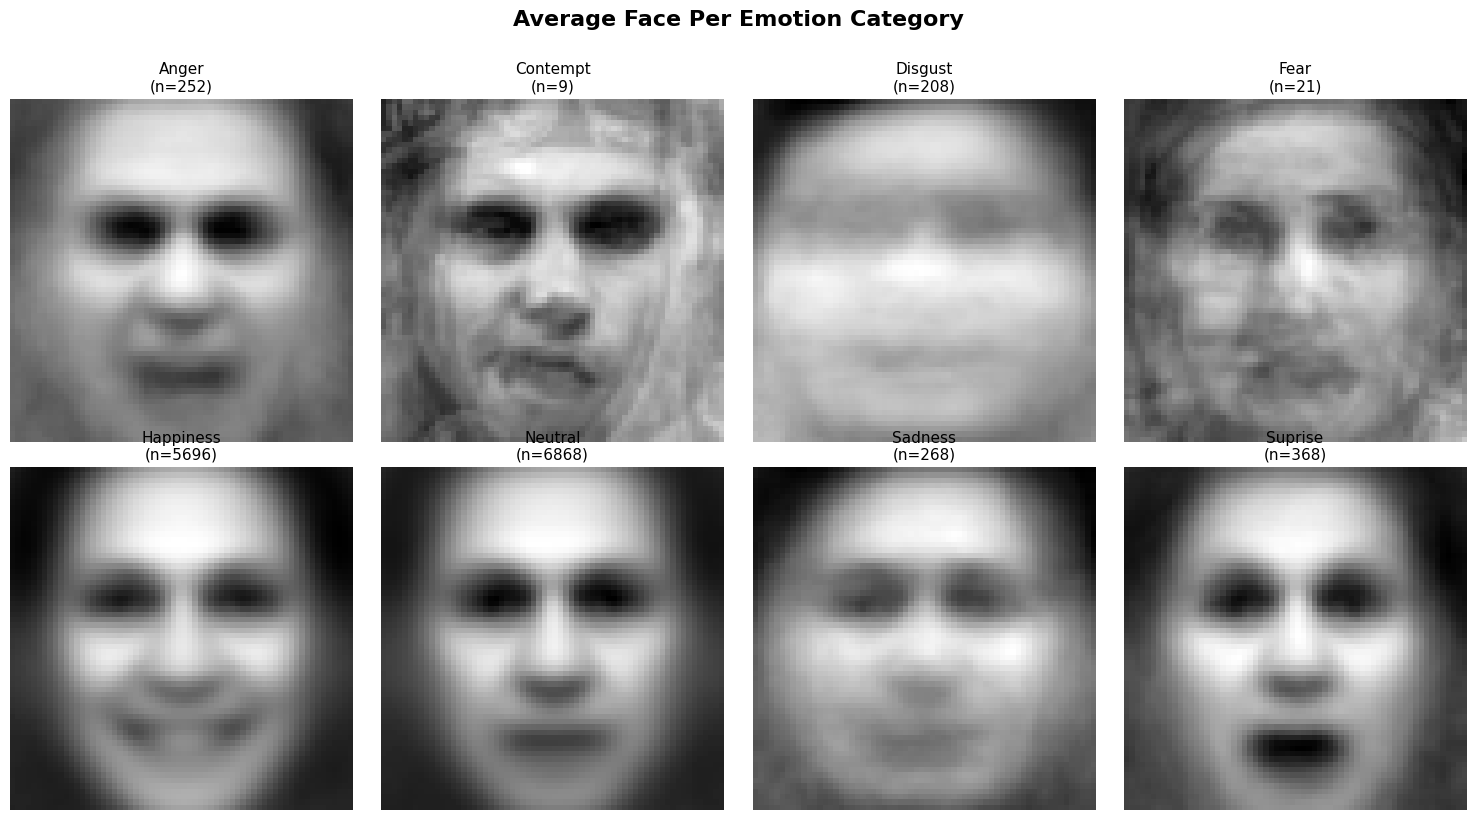

In [8]:
# 4. Average Face per Emotion Category
fig, axes = plt.subplots(2, (n_emotions + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, emotion in enumerate(unique_emotions):
    # Calculate mean face for this emotion
    emotion_images = X[y == emotion]
    mean_face = emotion_images.mean(axis=0).reshape(64, 64)
    
    axes[i].imshow(mean_face, cmap='gray')
    axes[i].set_title(f'{emotion.capitalize()}\n(n={len(emotion_images)})', fontsize=11)
    axes[i].axis('off')

# Hide any extra subplots
for j in range(len(unique_emotions), len(axes)):
    axes[j].axis('off')

plt.suptitle('Average Face Per Emotion Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

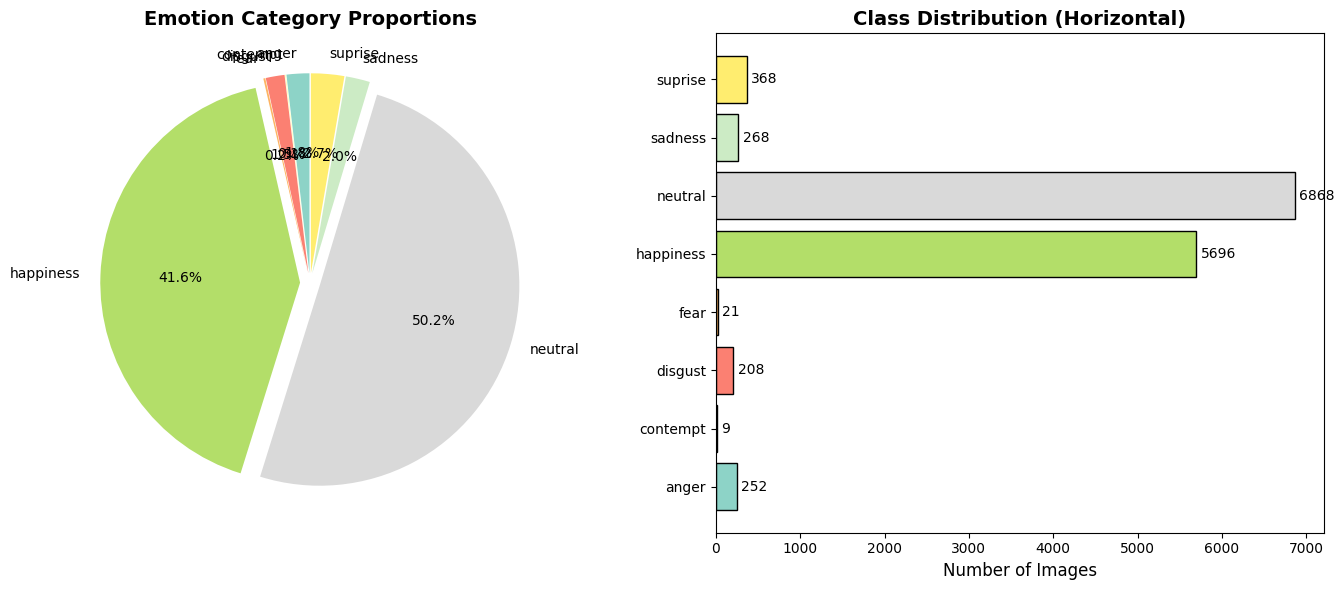


=== Class Imbalance Analysis ===
Largest class: neutral with 6868 samples
Smallest class: contempt with 9 samples
Imbalance ratio (max/min): 763.11x


In [10]:
# 5. Class Imbalance Visualization - Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))
wedges, texts, autotexts = axes[0].pie(emotion_counts.values, labels=emotion_counts.index, 
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        explode=[0.05] * len(emotion_counts))
axes[0].set_title('Emotion Category Proportions', fontsize=14, fontweight='bold')

# Horizontal bar chart for better comparison
y_pos = np.arange(len(emotion_counts))
axes[1].barh(y_pos, emotion_counts.values, color=colors, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(emotion_counts.index)
axes[1].set_xlabel('Number of Images', fontsize=12)
axes[1].set_title('Class Distribution (Horizontal)', fontsize=14, fontweight='bold')

# Add count labels
for i, (count, y) in enumerate(zip(emotion_counts.values, y_pos)):
    axes[1].text(count + 50, y, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
max_class = emotion_counts.max()
min_class = emotion_counts.min()
print(f"\n=== Class Imbalance Analysis ===")
print(f"Largest class: {emotion_counts.idxmax()} with {max_class} samples")
print(f"Smallest class: {emotion_counts.idxmin()} with {min_class} samples")
print(f"Imbalance ratio (max/min): {max_class/min_class:.2f}x")

## Training Data Splitting

In [48]:
# 10% data is used as testing data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

# Scaling
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)     # We can forget about the original values & work
X_te = scaler.transform(X_te)

## Logistic Regression Model

In [70]:
# logreg_cv = LogisticRegressionCV(
#     Cs=[0.001, 0.01, 0.1, 1, 10, 100], # The values to explore
#     cv=5,                              # Split training data into 5 folds
#     class_weight='balanced',           # Handle the "Disgust" imbalance
#     max_iter=1000,
#     random_state=seed
# )

# logreg_cv.fit(X_tr, y_tr)

# y_tr_pred = logreg_cv.predict(X_tr)
# y_te_pred = logreg_cv.predict(X_te)
# y_tr_error_rate = np.mean(y_tr != y_tr_pred)
# y_te_error_rate = np.mean(y_te != y_te_pred)


logreg = LogisticRegression(
    C = 0.1,                    
    class_weight='balanced',    
    max_iter=1000,
    random_state=seed
)

logreg.fit(X_tr, y_tr)

y_tr_pred = logreg.predict(X_tr)
y_te_pred = logreg.predict(X_te)
y_tr_error_rate = np.mean(y_tr != y_tr_pred)
y_te_error_rate = np.mean(y_te != y_te_pred)

In [71]:
print(y_tr_error_rate)
print(y_te_error_rate)

0.12929145361577793
0.3330898466033601
